# Imports and Setup

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Initial data investigation

In [2]:
postings = pd.read_csv('data/postings.csv')
postings.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'zip_code', 'fips'],
      dtype='object')

In [3]:
zip_state_map = pd.read_csv('data/us_zip_code_mapping.csv')
postings = pd.merge(postings, zip_state_map, on='zip_code', how='left')
display(postings.head())

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,work_type,currency,compensation_type,normalized_salary,zip_code,fips,usps_default_state,state,usps_default_city,metro_area
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,NJ,New Jersey,Princeton,"Trenton-Princeton, NJ"
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0,CO,Colorado,Fort Collins,"Fort Collins-Loveland, CO"
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,OH,Ohio,Cincinnati,"Cincinnati, OH-KY-IN"
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,NY,New York,New Hyde Park,"New York-Newark-Jersey City, NY-NJ"
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0,IA,Iowa,Burlington,"Burlington, IA-IL"


In [4]:
postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

In [5]:
postings.describe()

,job_id,max_salary,company_id,views,med_salary,min_salary,applies,original_listed_time,remote_allowed,expiry,closed_time,listed_time,sponsored,normalized_salary,zip_code,fips
count,1.238490e+05,2.979300e+04,1.221320e+05,122160.000000,6280.000000,2.979300e+04,23320.000000,1.238490e+05,15246.0,1.238490e+05,1.073000e+03,1.238490e+05,123849.0,3.607300e+04,102977.000000,96434.000000
mean,3.896402e+09,9.193942e+04,1.220401e+07,14.618247,22015.619876,6.491085e+04,10.591981,1.713152e+12,1.0,1.716213e+12,1.712928e+12,1.713204e+12,0.0,2.053270e+05,50400.491887,28713.879887
std,8.404355e+07,7.011101e+05,2.554143e+07,85.903598,52255.873846,4.959738e+05,29.047395,4.848209e+08,0.0,2.321394e+09,3.622893e+08,3.989122e+08,0.0,5.097627e+06,30252.232515,16015.929825
min,9.217160e+05,1.000000e+00,1.009000e+03,1.000000,0.000000,1.000000e+00,1.000000,1.701811e+12,1.0,1.712903e+12,1.712346e+12,1.711317e+12,0.0,0.000000e+00,1001.000000,1003.000000
25%,3.894587e+09,4.828000e+01,1.435200e+04,3.000000,18.940000,3.700000e+01,1.000000,1.712863e+12,1.0,1.715481e+12,1.712670e+12,1.712886e+12,0.0,5.200000e+04,24112.000000,13121.000000
50%,3.901998e+09,8.000000e+04,2.269650e+05,4.000000,25.500000,6.000000e+04,3.000000,1.713395e+12,1.0,1.716042e+12,1.712670e+12,1.713408e+12,0.0,8.150000e+04,48059.000000,29183.000000
75%,3.904707e+09,1.400000e+05,8.047188e+06,8.000000,2510.500000,1.000000e+05,8.000000,1.713478e+12,1.0,1.716088e+12,1.713283e+12,1.713484e+12,0.0,1.250000e+05,78201.000000,42077.000000
max,3.906267e+09,1.200000e+08,1.034730e+08,9975.000000,750000.000000,8.500000e+07,967.000000,1.713573e+12,1.0,1.729125e+12,1.713562e+12,1.713573e+12,0.0,5.356000e+08,99901.000000,56045.000000


In [6]:
postings.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'zip_code', 'fips',
       'usps_default_state', 'state', 'usps_default_city', 'metro_area'],
      dtype='object')

In [7]:
for col in ['pay_period', 'work_type', 'formatted_work_type', 'application_type', 'formatted_experience_level','sponsored', 'compensation_type','currency']:
    print(f"{col}: {postings[col].unique()}")

pay_period: ['HOURLY' 'YEARLY' nan 'MONTHLY' 'WEEKLY' 'BIWEEKLY']
work_type: ['FULL_TIME' 'INTERNSHIP' 'CONTRACT' 'PART_TIME' 'TEMPORARY' 'VOLUNTEER'
 'OTHER']
formatted_work_type: ['Full-time' 'Internship' 'Contract' 'Part-time' 'Temporary' 'Volunteer'
 'Other']
application_type: ['ComplexOnsiteApply' 'SimpleOnsiteApply' 'OffsiteApply' 'UnknownApply']
formatted_experience_level: [nan 'Entry level' 'Mid-Senior level' 'Associate' 'Director' 'Internship'
 'Executive']
sponsored: [0]
compensation_type: ['BASE_SALARY' nan]
currency: ['USD' nan 'CAD' 'BBD' 'EUR' 'AUD' 'GBP']


In [8]:
postings['normalized_salary'].describe()
# min 0, max 535,600,000.0 -> is this right? these should be normalized to annual salary

count    3.607300e+04
mean     2.053270e+05
std      5.097627e+06
min      0.000000e+00
25%      5.200000e+04
50%      8.150000e+04
75%      1.250000e+05
max      5.356000e+08
Name: normalized_salary, dtype: float64

In [9]:
print(sum(postings['normalized_salary']==0)) # 14 jobs where salary = 0
print(sum((postings['normalized_salary']> 0) & (postings['normalized_salary']<100) )) # 317 where 0 < salary < 100
print(sum(postings['normalized_salary']>1000000)) # 38 where salary > 1M

14
317
38


In [11]:
def examine_posting(posting):
    posting.reset_index()
    print(posting['title'][0])
    print(posting['min_salary'][0], posting['normalized_salary'][0], posting['max_salary'][0])
    print(posting['pay_period'][0], posting['formatted_work_type'][0])
    print(posting['description'][0])
    print("----")

# check postings w/ extreme values
examine_posting(postings[postings['normalized_salary']==0].head(1).reset_index())
examine_posting(postings[postings['normalized_salary']<1000].head(1).reset_index())
examine_posting(postings[postings['normalized_salary']>1000000].head(1).reset_index())
examine_posting(postings[postings['normalized_salary']>5000000].head(1).reset_index())

Independent Sales Representative
nan 0.0 nan
YEARLY Contract
Location: Remote
Job Type: Commission-Based
About Us: Odin Disc Golf is an innovative newcomer to the sports apparel scene, dedicated to transforming the disc golf experience. Our flagship product, the Original ODIN Disc Golf Jacket, blends cutting-edge design with premium materials to elevate performance and style on the course.
Job Description: We're seeking motivated Independent Sales Representatives to leverage their sales expertise in generating sales for the Original ODIN Disc Golf Jacket. As a key member of our team, you'll play a pivotal role in introducing our brand to the market and driving revenue growth.
Responsibilities:Use your sales experience to generate sales for the Original ODIN Disc Golf Jacket.
Requirements:Previous sales experience, preferably within the sports apparel or outdoor recreation industry.Genuine passion for disc golf and understanding of its community and culture.Strong communication and inte

Observations:
* it is possible for a 0 salary, if it's unpaid or sales-based (so guaranteed salary is 0)
* sometimes HOURLY/YEARLY is inaccurate
* if normalized salary >0 but <1000, salary should likely be 100x (e.g. it says 200 but should be 200,000)
* sometimes min/max salary seems correct but the normalized salary is just incorrect, and should be fixed
  * e.g. min 240000.0, max 275000.0, but normalized is 535600000.0 

# Clean data

## Remove duplicate postings

In [13]:
print(len(postings))
postings.drop_duplicates(subset=['description'], inplace=True)
print(len(postings))

123849
107828


## Fix Salaries

In [14]:
corrected_salaries = []

for iter,row in postings.iterrows():
  if ~np.isnan(row['min_salary']) & ~np.isnan(row['max_salary']):
    avg_salary = (row['max_salary']+row['min_salary'])/2
    if avg_salary < 50:
      corrected_salaries.append(avg_salary*2080) # 2080 hours in a work year
    elif avg_salary < 1000:
      corrected_salaries.append(avg_salary*1000)
    else:
      corrected_salaries.append(avg_salary)
  elif row['normalized_salary'] < 50:
    corrected_salaries.append(row['normalized_salary']*2080) # 2080 hours in a work year
  elif row['normalized_salary'] < 1000:
    corrected_salaries.append(row['normalized_salary']*1000)
  else:
    corrected_salaries.append(row['normalized_salary'])

postings['corrected_salary'] = corrected_salaries
postings.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,currency,compensation_type,normalized_salary,zip_code,fips,usps_default_state,state,usps_default_city,metro_area,corrected_salary
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,USD,BASE_SALARY,38480.0,8540.0,34021.0,NJ,New Jersey,Princeton,"Trenton-Princeton, NJ",38480.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,USD,BASE_SALARY,83200.0,80521.0,8069.0,CO,Colorado,Fort Collins,"Fort Collins-Loveland, CO",83200.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,USD,BASE_SALARY,55000.0,45202.0,39061.0,OH,Ohio,Cincinnati,"Cincinnati, OH-KY-IN",55000.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,USD,BASE_SALARY,157500.0,11040.0,36059.0,NY,New York,New Hyde Park,"New York-Newark-Jersey City, NY-NJ",157500.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,USD,BASE_SALARY,70000.0,52601.0,19057.0,IA,Iowa,Burlington,"Burlington, IA-IL",70000.0


In [15]:
print(postings['normalized_salary'].describe())
print(postings['corrected_salary'].describe())

count    3.380200e+04
mean     2.010198e+05
std      5.018215e+06
min      0.000000e+00
25%      5.200000e+04
50%      8.250000e+04
75%      1.250000e+05
max      5.356000e+08
Name: normalized_salary, dtype: float64
count    3.380200e+04
mean     9.362039e+04
std      5.602229e+05
min      0.000000e+00
25%      5.150000e+04
50%      7.500000e+04
75%      1.144000e+05
max      1.025000e+08
Name: corrected_salary, dtype: float64


## Normalize job titles


In [16]:
postings['title_normalized'] = postings['title'].str.strip().str.lower()

# expand abbrevs
postings['title_normalized'] = postings['title_normalized'].replace(r'\bsr.\b', 'senior', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\bassoc.\b', 'associate', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\bdir.\b', 'director', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\bmgr\b', 'manager', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\bvp\b', 'vice president', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\bvp.\b', 'vice president', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\bvp,?\b', 'vice president', regex=True)

# move levels to another column
postings['level_senior'] = postings['title_normalized'].str.contains('\bsenior\b', case=False)
postings['level_lead'] = postings['title_normalized'].str.contains('lead', case=False)
postings['level_associate'] = postings['title_normalized'].str.contains('associate', case=False)
postings['level_manager'] = postings['title_normalized'].str.contains('manager', case=False)
postings['level_director'] = postings['title_normalized'].str.contains('director', case=False)
postings['level_principal'] = postings['title_normalized'].str.contains('principal', case=False)
postings['level_vice_president'] = postings['title_normalized'].str.contains('vice president', case=False)
postings['level_chief'] = postings['title_normalized'].str.contains('chief', case=False)
postings['level_intern'] = postings['title_normalized'].str.contains('intern', case=False)
postings['level_junior'] = postings['title_normalized'].str.contains('junior', case=False)

# replace levels in title_normalized
postings['title_normalized'] = postings['title_normalized'].replace(r'\bsenior\b', '', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\blead\b', '', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'associate', '', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'manager', '', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'director', '', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'principal', '', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'vice president', '', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\bchief\b', '', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'intern', '', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\bjunior\b', '', regex=True)

# weird formatting

postings['title_normalized'] = postings['title_normalized'].replace(r'\bFP\ampA\b', 'finance', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\b\amp\b', 'and', regex=True)
postings['title_normalized'] = postings['title_normalized'].replace(r'\b/\b', 'and', regex=True)

postings['title_normalized'] = postings['title_normalized'].str.split(',').str[0] # remove anything after a comma
postings['title_normalized'] = postings['title_normalized'].str.split(' - ').str[0] # remove anything after a " - "
postings['title_normalized'] = postings['title_normalized'].str.replace(r'\(.*\)', '', regex=True).str.strip() # remove anything in ()


# misspellings
postings['title_normalized'] = postings['title_normalized'].replace(r'\bassitant\b', 'assistant', regex=True)


display(postings[['title', 'title_normalized']].head(25))

,title,title_normalized
0,Marketing Coordinator,marketing coordinator
1,Mental Health Therapist/Counselor,mental health therapistandcounselor
2,Assitant Restaurant Manager,assistant restaurant
3,Senior Elder Law / Trusts and Estates Associat...,elder law / trusts and estates attorney
4,Service Technician,service technician
5,Economic Development and Planning Intern,economic development and planning
6,Producer,producer
7,Building Engineer,building engineer
8,Respiratory Therapist,respiratory therapist
9,Worship Leader,worship leader


In [17]:
print(len(postings['title'].unique()))
print(len(postings['title_normalized'].unique()))

69925
46575


## Fix timestamps

In [21]:
postings['original_listed_time_ts'] = pd.to_datetime(postings['original_listed_time'], unit='ms')
postings['listed_time_ts'] = pd.to_datetime(postings['listed_time'], unit='ms')
postings['closed_time_ts'] = pd.to_datetime(postings['closed_time'], unit='ms')
postings['time_open'] = postings['closed_time_ts'] - postings['listed_time_ts']

In [75]:
print(min(postings['original_listed_time_ts']), max(postings['original_listed_time_ts']))

2023-12-05 21:08:53 2024-04-20 00:26:30


In [76]:
print(min(postings['listed_time_ts']), max(postings['listed_time_ts']))

2024-04-05 19:34:32 2024-04-20 00:26:56


## Save cleaned set

In [22]:
postings.to_csv('data/postings_cleaned.csv', index=False)

# Evaluate data

In [23]:
postings.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'zip_code', 'fips',
       'usps_default_state', 'state', 'usps_default_city', 'metro_area',
       'corrected_salary', 'title_normalized', 'level_senior', 'level_lead',
       'level_associate', 'level_manager', 'level_director', 'level_principal',
       'level_vice_president', 'level_chief', 'level_intern', 'level_junior',
       'original_listed_time_ts', 'listed_time_ts', 'closed_time_ts',
       'time_open'],
      dtype='object')

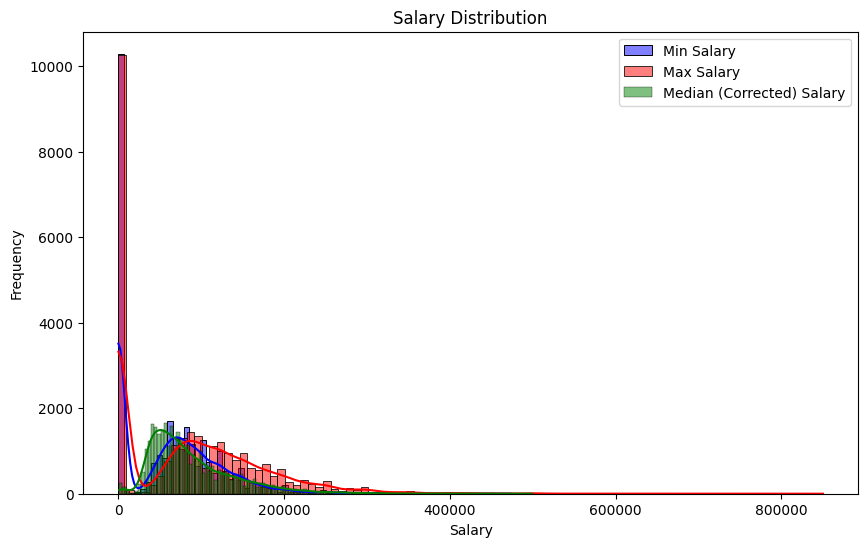

In [43]:
postings_filtered = postings[
    (postings['corrected_salary']>0) &
    (postings['corrected_salary']<500000)
]

plt.figure(figsize=(10, 6))

# Plot salary distribution (min_salary, med_salary, max_salary)
sns.histplot(postings_filtered['min_salary'], color='blue', kde=True, label='Min Salary', alpha=0.5)
sns.histplot(postings_filtered['max_salary'], color='red', kde=True, label='Max Salary', alpha=0.5)
sns.histplot(postings_filtered['corrected_salary'], color='green', kde=True, label='Median (Corrected) Salary', alpha=0.5)

plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend()
plt.show()


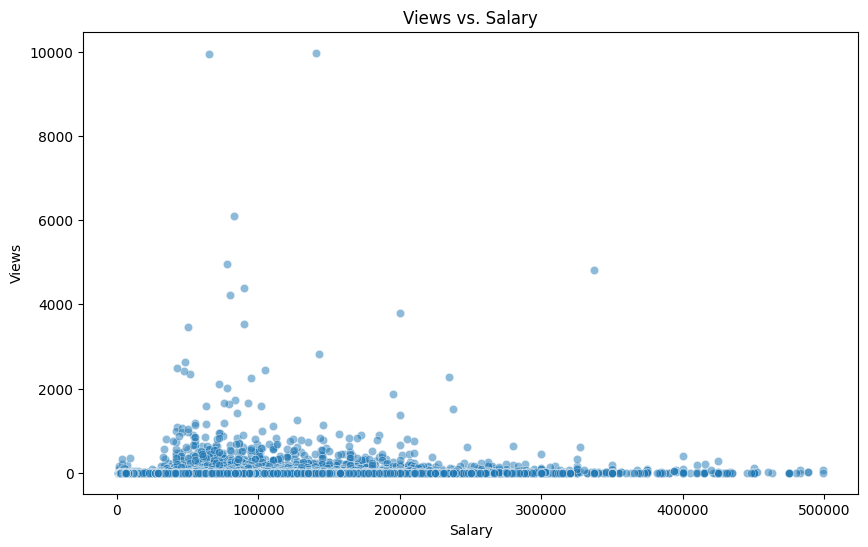

In [53]:
# Scatter plot of views vs. salary
plt.figure(figsize=(10,6))
sns.scatterplot(x=postings_filtered['corrected_salary'], y=postings['views'], alpha=0.5)
plt.title('Views vs. Salary')
plt.xlabel('Salary')
plt.ylabel('Views')
plt.show()


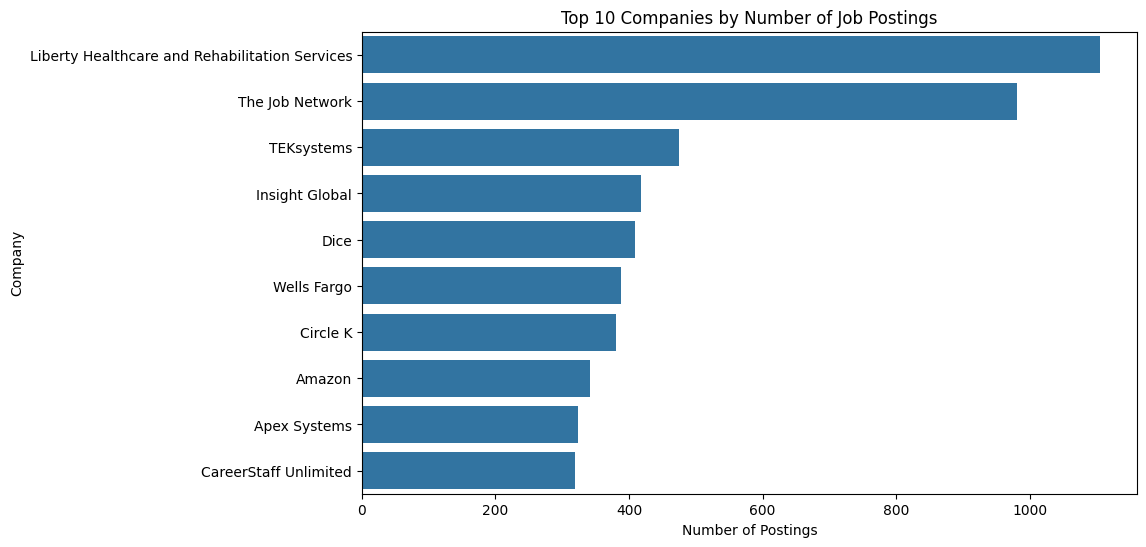

In [51]:
top_companies = postings['company_name'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_companies.values,
    y=top_companies.index,
)
plt.title('Top 10 Companies by Number of Job Postings')
plt.xlabel('Number of Postings')
plt.ylabel('Company')
plt.show()

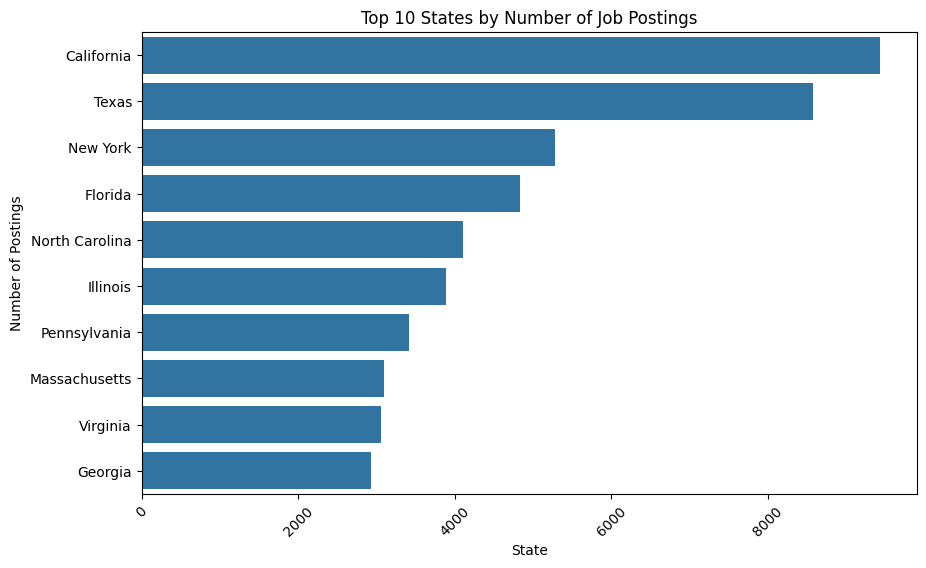

In [65]:
location_counts = postings['state'].value_counts().head(10)  # Top 10 states with most job postings

plt.figure(figsize=(10, 6))
sns.barplot(
    x=location_counts.values,
    y=location_counts.index,
)
plt.title('Top 10 States by Number of Job Postings')
plt.xlabel('State')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45)
plt.show()

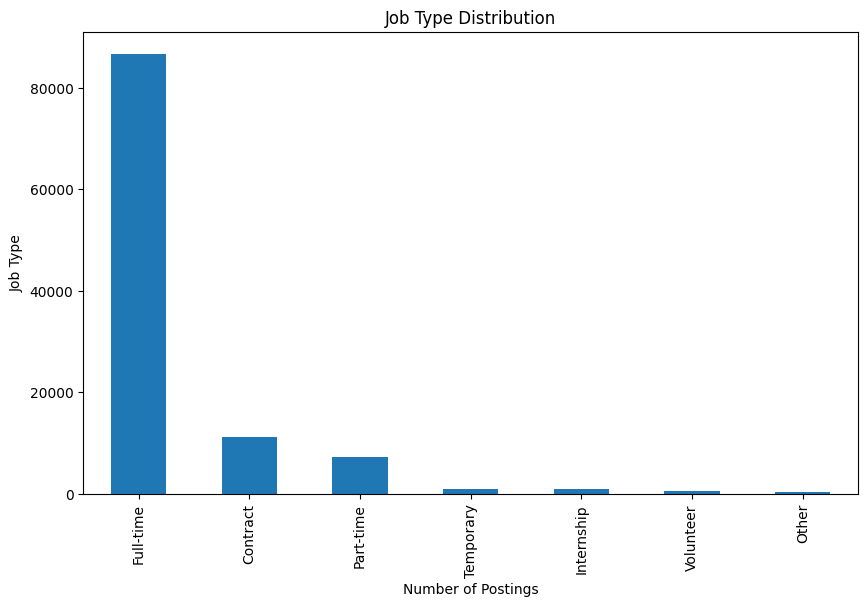

In [63]:
work_type_counts = postings['formatted_work_type'].value_counts()

plt.figure(figsize=(10,6))
work_type_counts.plot(kind='bar')
plt.title('Job Type Distribution')
plt.xlabel('Number of Postings')
plt.ylabel('Job Type')
plt.show()

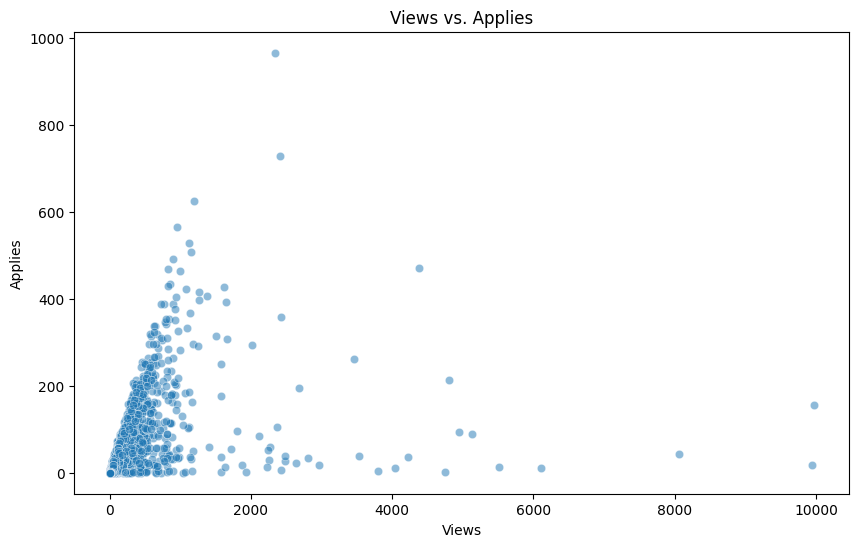

In [89]:
# Scatter plot of views vs. applies
plt.figure(figsize=(10,6))
sns.scatterplot(x=postings['views'], y=postings['applies'], alpha=0.5)
plt.title('Views vs. Applies')
plt.xlabel('Views')
plt.ylabel('Applies')
plt.show()

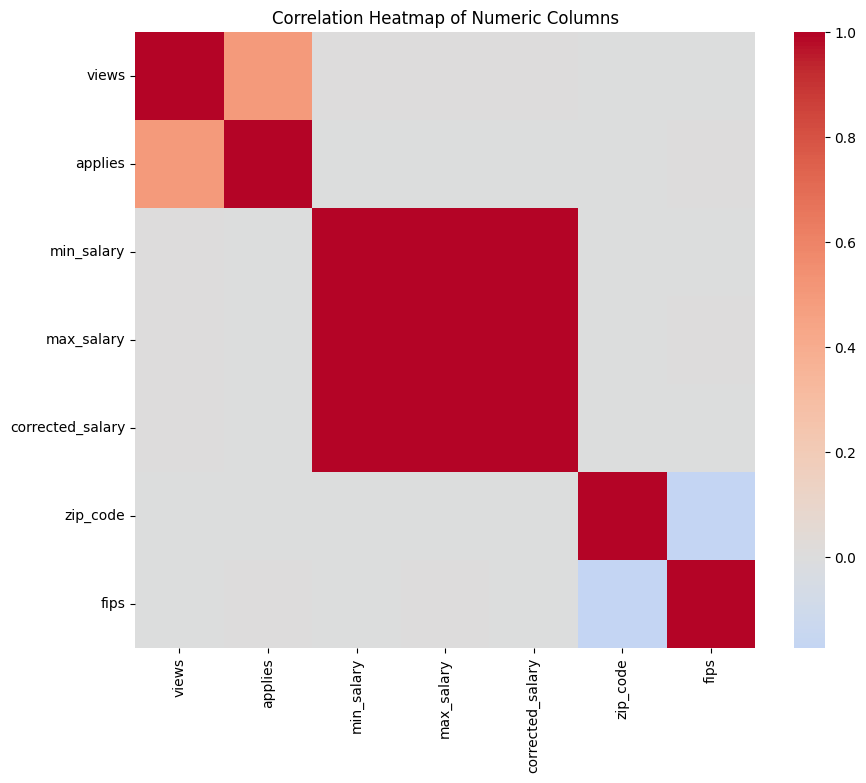

In [87]:
postings_subset = postings[['views', 'applies', 'min_salary', 'max_salary', 'corrected_salary', 'zip_code', 'fips']]

numeric_cols = postings_subset.select_dtypes(include='number')
corr = numeric_cols.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

## Data Science jobs

In [68]:
data_science_job_titles = []

for title in postings.title_normalized.unique():
  is_scientist = 'scien' in title.lower()
  is_data = 'data' in title.lower()
  is_computer = 'computer' in title.lower()

  if is_scientist & is_data & (not is_computer):
    #print(title)
    data_science_job_titles.append(title)

data_science_postings = postings[postings.title_normalized.isin(data_science_job_titles)]
data_science_postings.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,level_director,level_principal,level_vice_president,level_chief,level_intern,level_junior,original_listed_time_ts,listed_time_ts,closed_time_ts,time_open
366,3800272386,Sovrinti,Data Science Software Engineer,Company Overview Sovrinti is a full-service en...,NaN,NaN,United States,80936343.0,125.0,NaN,...,False,False,False,False,False,False,2024-01-08 17:58:59,2024-04-05 19:55:49,NaT,NaT
1338,3884435309,Armstrong World Industries,Data Scientist Job,"Primary location: Remote, Remote\n\nRelocation...",NaN,NaN,United States,5968.0,164.0,NaN,...,False,False,False,False,False,False,2024-04-05 20:08:19,2024-04-05 20:20:18,NaT,NaT
2887,3884818921,Data Glacier,NLP/data science/Data Analysis(Intern apr 30),The ideal candidate will use their passion for...,NaN,NaN,United States,69739391.0,131.0,NaN,...,False,False,False,False,True,False,2024-04-06 02:33:36,2024-04-06 02:33:36,NaT,NaT
2951,3884820711,Data Glacier,Data Science intern ( Apr 30),Unpaid internship hence no compensation or sti...,NaN,NaN,United States,69739391.0,37.0,NaN,...,False,False,False,False,True,False,2024-04-06 02:31:21,2024-04-06 02:31:21,NaT,NaT
3566,3884838060,Pacific Northwest National Laboratory,Senior Data Scientist 3 - Nonproliferation,Overview\n\nProtecting U.S. residents and visi...,219500.0,YEARLY,"Richland, WA",4714.0,4.0,NaN,...,False,False,False,False,False,False,2024-04-06 03:26:09,2024-04-06 03:37:40,NaT,NaT


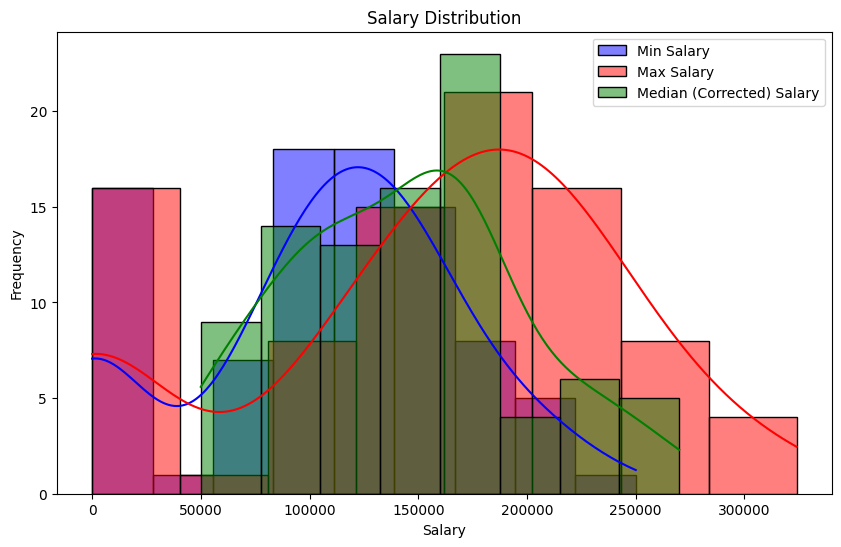

In [70]:
ds_postings_filtered = data_science_postings[
    (data_science_postings['corrected_salary']>0) &
    (data_science_postings['corrected_salary']<1000000)
]

plt.figure(figsize=(10, 6))

# Plot salary distribution (min_salary, med_salary, max_salary)
sns.histplot(ds_postings_filtered['min_salary'], color='blue', kde=True, label='Min Salary', alpha=0.5)
sns.histplot(ds_postings_filtered['max_salary'], color='red', kde=True, label='Max Salary', alpha=0.5)
sns.histplot(ds_postings_filtered['corrected_salary'], color='green', kde=True, label='Median (Corrected) Salary', alpha=0.5)

plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [80]:
ds_postings_filtered.groupby('formatted_experience_level').agg(min_norm_salary=('corrected_salary', 'min'), max_norm_salary=('corrected_salary', 'max'))

,min_norm_salary,max_norm_salary
formatted_experience_level,,
Associate,52500.0,100000.0
Director,150000.0,255500.0
Entry level,55000.0,208000.0
Executive,262500.0,262500.0
Mid-Senior level,50000.0,270000.0


In [81]:
ds_postings_filtered.groupby('state').agg(min_norm_salary=('corrected_salary', 'min'), max_norm_salary=('corrected_salary', 'max'))

,min_norm_salary,max_norm_salary
state,,
Alabama,107500.0,174600.0
California,58605.0,243500.0
Colorado,99500.0,123000.0
District Of Columbia,78665.5,178125.0
Florida,84500.0,180000.0
Illinois,102500.0,151900.0
Kentucky,74977.0,74977.0
Maryland,174000.0,174000.0
Massachusetts,52500.0,196000.0


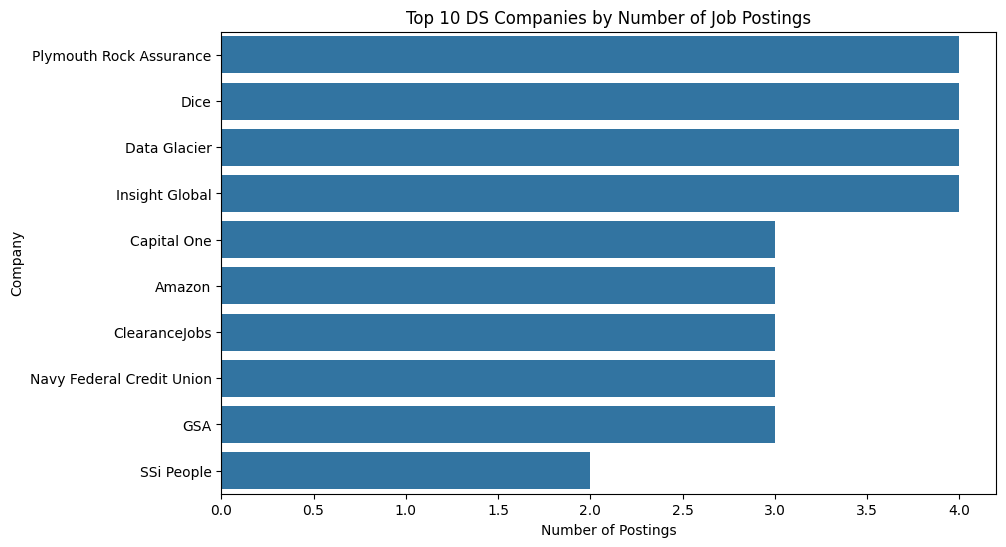

In [71]:
top_companies = data_science_postings['company_name'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_companies.values,
    y=top_companies.index,
)
plt.title('Top 10 DS Companies by Number of Job Postings')
plt.xlabel('Number of Postings')
plt.ylabel('Company')
plt.show()

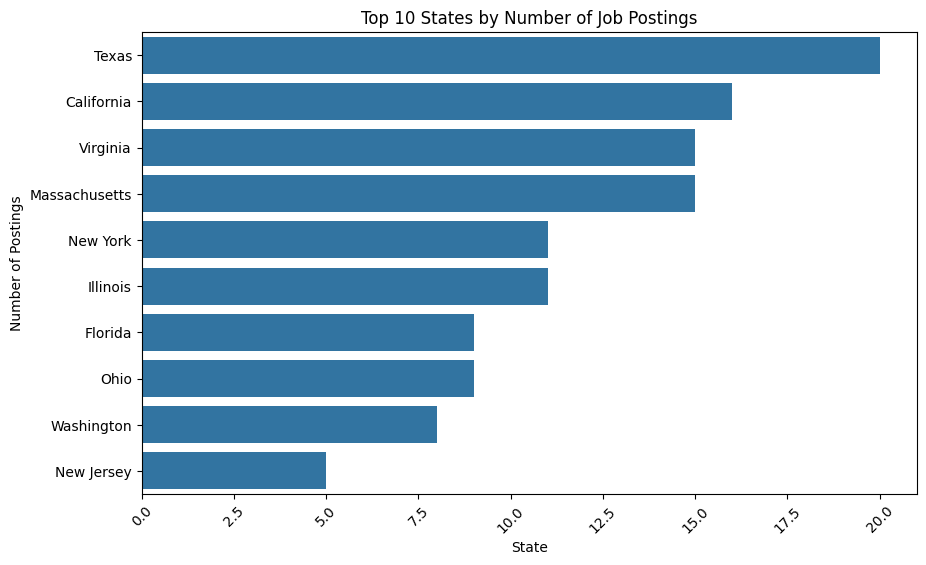

In [72]:
location_counts = data_science_postings['state'].value_counts().head(10)  # Top 10 states with most job postings

plt.figure(figsize=(10, 6))
sns.barplot(
    x=location_counts.values,
    y=location_counts.index,
)
plt.title('Top 10 States by Number of Job Postings')
plt.xlabel('State')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45)
plt.show()

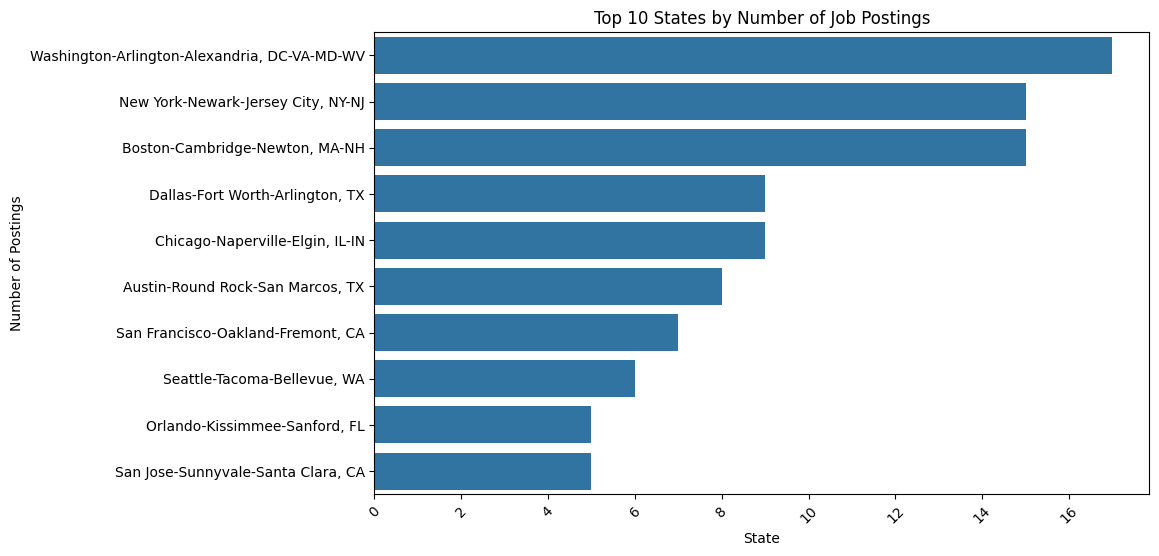

In [73]:
location_counts = data_science_postings['metro_area'].value_counts().head(10)  # Top 10 states with most job postings

plt.figure(figsize=(10, 6))
sns.barplot(
    x=location_counts.values,
    y=location_counts.index,
)
plt.title('Top 10 States by Number of Job Postings')
plt.xlabel('State')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45)
plt.show()